In [1]:
import re
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os
import time
import numpy as np
import pandas as pd 
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv

In [2]:
"""Reading the input data file """

raw_data = pd.read_excel('news_inshort.xlsx')
raw_data.head()

,short,long,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


In [3]:
"""shuffling the data of the input file """

raw_data = shuffle(raw_data)
raw_data.head()

,short,long,Source,Time,Publish Date
51423,One of Indonesia&#39;s oldest red-light area r...,Indonesian authorities on Monday closed brothe...,Outlook,18:38:00,2016-02-29
14219,Akshay only B&#39;wood actor to give three ₹10...,Akshay Kumar became the only Bollywood actor w...,Inshorts,14:35:00,2016-12-25
52677,Al-Shabaab claims Somalia plane bombing,"Al-Shabaab, al Qaeda&#39;s affiliate in Somali...",Xinhua News,12:36:00,2016-02-14
2138,Kareena replaces Katrina for performance at Ze...,Actress Kareena Kapoor has replaced Katrina Ka...,SpotboyE,17:30:00,2017-03-11
51617,Delhi Court discharges 2 terror suspects,"Due to lack of evidence, two suspected Indian ...",Phys,11:35:00,2016-02-27


In [4]:

"""Creating seperate dataframes for the actual news and for the short summary """

short_summary, actual_news = pd.DataFrame(), pd.DataFrame()
short_summary['short'] = raw_data['short']
actual_news['long'] = raw_data['long']
(short_summary.shape,actual_news.shape)

((55104, 1), (55104, 1))

In [5]:

"""Pre processing the data so as to obtain clean sentences to generate tokens.
Doing lower casing,normalization,removing special characters etc. """

def data_preprocessing(text_line):
    text_line = str(text_line).lower()
    text_line = unicodedata.normalize('NFKD', text_line).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    text_line = re.sub(r"http\S+","",text_line)
    text_line = re.sub(r"there's", "there is", text_line)
    text_line = re.sub(r"i'm", "i am", text_line)
    text_line = re.sub(r"he's", "he is", text_line)
    text_line = re.sub(r"she's", "she is", text_line)
    text_line = re.sub(r"it's", "it is", text_line)
    text_line = re.sub(r"that's", "that is", text_line)
    text_line = re.sub(r"what's", "that is", text_line)
    text_line = re.sub(r"where's", "where is", text_line)
    text_line = re.sub(r"how's", "how is", text_line)
    text_line = re.sub(r"\'ll", " will", text_line)
    text_line = re.sub(r"\'ve", " have", text_line)
    text_line = re.sub(r"\'re", " are", text_line)
    text_line = re.sub(r"\'d", " would", text_line)
    text_line = re.sub(r"\'re", " are", text_line)
    text_line = re.sub(r"won't", "will not", text_line)
    text_line = re.sub(r"can't", "cannot", text_line)
    text_line = re.sub(r"n't", " not", text_line)
    text_line = re.sub(r"n'", "ng", text_line)
    text_line = re.sub(r"'bout", "about", text_line)
    text_line = re.sub(r"'til", "until", text_line)
    text_line = re.sub(r"\"", "", text_line)
    text_line = re.sub(r"\'", "", text_line)
    text_line = re.sub(r' s ', "",text_line)
    text_line = re.sub(r"&39", "", text_line)
    text_line = re.sub(r"&34", "", text_line)
    text_line = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", text_line)
    text_line = re.sub(r"&", "", text_line)
    text_line = re.sub(r"\\n", "", text_line)
    text_line = text_line.strip()
    return text_line

In [6]:
"""performing the data pre processing on both the short summary and the actual news """

short_summary['short'] = short_summary['short'].apply(lambda x: data_preprocessing(x))
actual_news['long'] = actual_news['long'].apply(lambda x: data_preprocessing(x))
actual_news.head()

,long
51423,indonesian authorities on monday closed brothe...
14219,akshay kumar became the only bollywood actor w...
52677,alshabaab al qaedas affiliate in somalia on sa...
2138,actress kareena kapoor has replaced katrina ka...
51617,due to lack of evidence two suspected indian m...


In [7]:
"""Initialising the start and the ned tokens"""
start_token, end_token = '<startseq>' , '<endseq>'
short_summary = short_summary.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
short_summary.head()

,short
51423,<startseq> one of indonesias oldest redlight a...
14219,<startseq> akshay only bwood actor to give thr...
52677,<startseq> alshabaab claims somalia plane bomb...
2138,<startseq> kareena replaces katrina for perfor...
51617,<startseq> delhi court discharges terror susp...


In [8]:
#Splitting the dataset into training and validation

splitting_ratio_value = 0.1
# train validation split
short_summary_train = short_summary[int(len(short_summary)*splitting_ratio_value):]
short_summary_val = short_summary[:int(len(short_summary)*splitting_ratio_value)]
actual_news_train = actual_news[int(len(short_summary)*splitting_ratio_value):]
actual_news_val = actual_news[:int(len(short_summary)*splitting_ratio_value)]

len(actual_news_val),len(actual_news_train)

actual_news_train.iloc[0], short_summary_train.iloc[0]

(long    agra and sikkim have featured in the  places t...
 Name: 12120, dtype: object,
 short    <startseq> agra sikkim feature in  places to g...
 Name: 12120, dtype: object)

In [9]:

BUFFER_SIZE = 20000
BATCH_SIZE = 64
dimension_embedding = 200

In [10]:
#Calculating the length which is maximum for most of the text_lines in the dataset

def calcualting_maximum_length(shorts, longs, percent):
    
    actual_news_length = list(len(d.split()) for d in longs)
    short_summary_length = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(percent,np.percentile(actual_news_length, percent)))
    print('longest text_line: ', max(actual_news_length))
    print()
    print('percentile {} of length of short_summary: {}'.format(percent,np.percentile(short_summary_length, percent)))
    print('longest text_line: ', max(short_summary_length))
    print()
    return int(np.percentile(actual_news_length, percent)),int(np.percentile(short_summary_length, percent))

In [11]:
# selecting text_line length based on the percentile of data that fits in the length
actual_news_maximum_length, short_summary_maximum_length= calcualting_maximum_length(short_summary_train['short'].to_list(), actual_news_train['long'].to_list(), 90)
print('max-length actual_news chosen for training: ', actual_news_maximum_length)
print('max-length short_summary chosen for training: ', short_summary_maximum_length)

percentile 90 of length of news: 60.0
longest text_line:  66

percentile 90 of length of short_summary: 12.0
longest text_line:  16

max-length actual_news chosen for training:  60
max-length short_summary chosen for training:  12


In [12]:
# making a vocabulary of the words 
def word_collection(shorts, longs = None, minimum_occurances = 3):
    # Create a list of all the captions
    word_list = []
    for s in shorts:
        word_list.append(s)
    # Consider only words which occur at least minimum_occurrence times in the corpus
    counter_words = {}
    counter = 0
    for line in word_list:
        counter += 1
        for w in line.split(' '):
            counter_words[w] = counter_words.get(w, 0) + 1
    word_collection = [w for w in counter_words if counter_words[w] >= minimum_occurances]
    word_collection = list(set(word_collection))
    return word_collection

In [13]:
decoder_vocabulary = word_collection(short_summary_train['short'].to_list(), minimum_occurances=5)
for v in decoder_vocabulary:
    if len(v) == 1 and v!='a' and v!='i':
        decoder_vocabulary.remove(v)
        
decoder_vocabulary = sorted(decoder_vocabulary)[1:]
decoder_vocabulary[:10]



['<endseq>',
 '<startseq>',
 'a',
 'aa',
 'aadhaar',
 'aadmi',
 'aam',
 'aamir',
 'aamirs',
 'aap']

In [14]:
encoder_vocabulary = word_collection(actual_news_train['long'].to_list(), minimum_occurances=3)

for v in encoder_vocabulary:
    if len(v) == 1 and v!='a' and v!='i':
        encoder_vocabulary.remove(v)
        
encoder_vocabulary = sorted(encoder_vocabulary)[1:]
encoder_vocabulary[:10]

['****ing',
 'a',
 'aa',
 'aaa',
 'aadhaar',
 'aadhaarbased',
 'aadhaarenabled',
 'aadhaarlinked',
 'aadhaars',
 'aadhar']

In [15]:

# removing all the out of the vocabulary words in the data and also making sure to remove all the non digits
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' 
actual_news_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
short_summary_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
actual_news_tokenizer.fit_on_texts(encoder_vocabulary)
short_summary_tokenizer.fit_on_texts(decoder_vocabulary)#short_summary_train['short'])



In [16]:
#Calcualting the vocabulary size of the encoders and the decoders
encoder_vocabulary_size = len(actual_news_tokenizer.word_index) + 1
decoder_vocabulary_size = len(short_summary_tokenizer.word_index) + 1
encoder_vocabulary_size, decoder_vocabulary_size

index_to_word_encoder = {}
index_to_word_decoder = {}

word_to_index_encoder = actual_news_tokenizer.word_index # word to index dic
index_to_word_encoder[0] = '<PAD0>'
index_to_word_decoder[0] = '<PAD0>'

In [17]:

for w in actual_news_tokenizer.word_index:
    index_to_word_encoder[actual_news_tokenizer.word_index[w]] = w

word_to_index_decoder = short_summary_tokenizer.word_index # word to index dic

for w in short_summary_tokenizer.word_index:
    index_to_word_decoder[short_summary_tokenizer.word_index[w]] = w

In [18]:
# assign a number to each word inorder to find it in word embeddings

input_words = actual_news_tokenizer.texts_to_sequences(actual_news_train['long'])
output_words = short_summary_tokenizer.texts_to_sequences(short_summary_train['short'])
input_words_val = actual_news_tokenizer.texts_to_sequences(actual_news_val['long'])
output_words_val = short_summary_tokenizer.texts_to_sequences(short_summary_val['short'])
input_words = krs.preprocessing.sequence.pad_sequences(input_words, maxlen=actual_news_maximum_length, padding='post', truncating='post')
output_words = krs.preprocessing.sequence.pad_sequences(output_words, maxlen=short_summary_maximum_length, padding='post', truncating='post')
input_words_val = krs.preprocessing.sequence.pad_sequences(input_words_val, maxlen=actual_news_maximum_length, padding='post', truncating='post')
output_words_val = krs.preprocessing.sequence.pad_sequences(output_words_val, maxlen=short_summary_maximum_length, padding='post', truncating='post')

In [19]:
# validate train split
dataset = tf.data.Dataset.from_tensor_slices((input_words,output_words)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((input_words_val,output_words_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

actual_news_val.reset_index(inplace=True, drop=True)
short_summary_val.reset_index(inplace=True, drop=True)
actual_news_train.reset_index(inplace=True, drop=True)
short_summary_train.reset_index(inplace=True, drop=True)




In [20]:
def plotting_graph(total_data):
    plt.title('Loss')
    x= [i[0] for i in total_data['val']]
    y=[i[1] for i in total_data['val']]
    plt.plot(x,y,'x-')
    x= [i[0] for i in total_data['train']]
    y=[i[1] for i in total_data['train']]
    plt.plot(x,y,'o-')
    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(total_data['val'],key=lambda x: x[1])[0])

In [21]:
"""The attention function used by the Transformer takes three inputs
q - Query, k- Key and v- Value and the dot product attention is scaled 
by a factor of square root of depth"""

def calculculate_scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights



In [22]:
"""Multihead attention has primarily four layers. First is Linear layers
split into heads Second is Scaled dot product attention, third is concatenation 
of heads and fourth is final linear layer """

class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads 
        self.wq = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wk = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wv = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    
    # reshape the Q,K,V 
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = calculculate_scaled_dot_product_attention(
            q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

In [25]:
"""for the creation of the embedding layer I am using the pre trained glove model
with 200 dimension"""

def embedding_layer_generator(vocabulary_length, wordtoindex, dimension_embedding=200, glove=True,
                              glove_path='./glove'):
    if glove == False:
        print('Zero MATRIX obtained')
        embedding_matrix = np.zeros((vocabulary_length, dimension_embedding))
    else:
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {}
        f = open(os.path.join(glove_dir, 'glove.6B.' + str(dimension_embedding) + 'd.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        embedding_matrix = np.zeros((vocabulary_length, dimension_embedding))
        for word, i in wordtoindex.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

        print("GloVe ", dimension_embedding, ' loaded!')

    embedding_layer = Embedding(vocabulary_length, dimension_embedding, mask_zero=True, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer




In [26]:
"""Generating the Embedding layer for the encoder and the decoder"""

embeddings_encoder = embedding_layer_generator(encoder_vocabulary_size, word_to_index_encoder,
                                               dimension_embedding=dimension_embedding, glove=True)
embeddings_decoder = embedding_layer_generator(decoder_vocabulary_size, word_to_index_decoder,
                                               dimension_embedding=dimension_embedding, glove=True)

Loading glove...
GloVe  200  loaded!
Loading glove...
GloVe  200  loaded!


In [27]:
"""The positional encoding vector is added to the embedding vector. The Embedding
dimension taken is 200 """

def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)




In [28]:
# hyper-params
init_lr = 1e-3
lmbda_l2 = 0.1
d_out_rate = 0.1 
num_layers = 4 
d_model = dimension_embedding
dff = 512 
num_heads = 5 

In [29]:
"""Point wise feed forward network consists of two fully connected layers with a ReLU activation
in between """

def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',kernel_regularizer=krs.regularizers.l2(l=lmbda_l2)),
        krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    ])



In [30]:
"""Each encoder layer consists of  sublayers - First is Multi head attention
with padding mask and the second is point wise feed forward networks. """


class EncoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
   
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2



In [31]:
""" Each decoder consists of sublayers. First is the Masked multi head attention
with look ahead mask and padding mask and the Second is Multi head attention with 
padding mask. V - values and k- key recieve the encoder output as input Q(query) 
and this recieves the output from the masked multi head attention sublyer. And the third is the
point wise feed forward network"""

class DecoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
        self.dropout3 = krs.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3, attn_weights_block1, attn_weights_block2

In [32]:
""" The Decoder consists of Output Embedding,Positional Embedding 
and N decoder layers. The target is put through an embedding which is 
summed up with the positional encoding. Output of the summation is the input to
the deocder layer. The output of decoder is input to linear layer """


class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding,
                 rate=d_out_rate):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = krs.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        return x, attention_weights





In [33]:
"""Masking all the pad tokens in the batch of sequence. This ensures that padding is not treated as input
it ouputs 1 where value of 0 is there and vice versa """

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

"""look ahead Mask is used to mask the future tokens in a sequence"""

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask





In [34]:
""" The Encoder primarily consists of Input Embedding,Positional Encoding,
and N encoder layers. The input is put through embedding which is summed up
with the positional encoding """

class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = krs.layers.Dropout(rate)
        self.dropout_embd = krs.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) 
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x



In [35]:
"""Transformer consist of the Encoder,Decoder and a final layer. The output of the decoder is the 
input to the linear layer and its output is returned."""

class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights



In [36]:
"""hyperparameters of the Transformer """

transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocabulary_size,
    decoder_vocabulary_size,
    pe_input=actual_news_maximum_length,
    pe_target=short_summary_maximum_length,
)

lr_schedule = krs.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr, # originally was 1e-5
    decay_steps=4000, # approximately 5 epochs
    decay_rate=0.95) # originally was 0.9

optimizer2 = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) 
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')



In [37]:
def loss_function(real, pred, l2= False):
 
    if l2:
        lambda_ = 0.0001
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred) 
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)



In [38]:
""" Check point path and check point manager will be used to save check points every n seconds """

checkpoint_path4 ="checkpoints4"

ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)
ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)



In [39]:
def evaluate(input_document):
    input_document = actual_news_tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=actual_news_maximum_length,
                                                                           padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)
    decoder_input = [short_summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(short_summary_maximum_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        """ Stop the predictions as soon as the End token is noticed"""
        if predicted_id == short_summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights



In [40]:
def summary_generator(input_document):
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0) 
    return short_summary_tokenizer.sequences_to_texts(summarized)[0]

def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] 
        tar_real = tar[:, 1:]
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()



In [41]:
""" The @tf.function trace compiles train_steps into a TF graph for faster execution."""

@tf.function 
def train_step(inp, tar):
    tar_inp = tar[:, :-1] 
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)



In [42]:
total_data={'val':[],'train':[]}
EPOCHS =20
not_progressing = 0
train_loss = krs.metrics.Mean(name='train_loss')
val_loss = krs.metrics.Mean(name='val_loss')

params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params



{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 200,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

Epoch 1 Batch 0 Loss 9.1191
Epoch 1 Batch 150 Loss 7.0757
Epoch 1 Batch 300 Loss 6.9545
Epoch 1 Batch 450 Loss 6.8719
Epoch 1 Batch 600 Loss 6.8129
Epoch 1 Batch 750 Loss 6.7656

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 6.393139362335205 

* Train Loss 6.7591

Saving checkpoint for epoch 1 at checkpoints4/ckpt-1


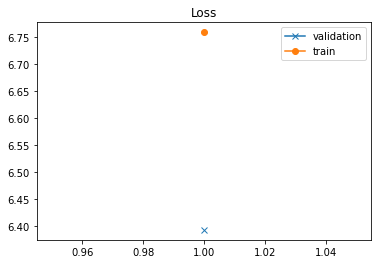

smallest val loss: (1, 6.3931394)
Current Lr:  0.0009901111

Time taken for this epoch: 402.90 secs

Epoch 2 Batch 0 Loss 6.6625
Epoch 2 Batch 150 Loss 6.4700
Epoch 2 Batch 300 Loss 6.4550
Epoch 2 Batch 450 Loss 6.4462
Epoch 2 Batch 600 Loss 6.4265
Epoch 2 Batch 750 Loss 6.4091

<UNK> <UNK> <UNK> to <UNK> <UNK> in <UNK>
<UNK> <UNK> <UNK> to <UNK> <UNK> in <UNK>

validation started ...

* Validation loss: 6.1897873878479 

* Train Loss 6.4060

Saving checkpoint for epoch 2 at checkpoints4/ckpt-2


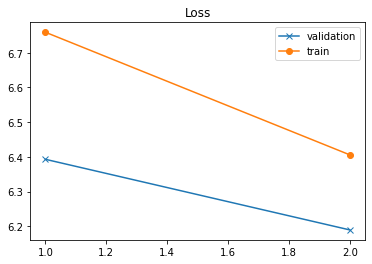

smallest val loss: (2, 6.1897874)
Current Lr:  0.0009803202

Time taken for this epoch: 394.69 secs

Epoch 3 Batch 0 Loss 6.0097
Epoch 3 Batch 150 Loss 6.2572
Epoch 3 Batch 300 Loss 6.2412
Epoch 3 Batch 450 Loss 6.2146
Epoch 3 Batch 600 Loss 6.1926
Epoch 3 Batch 750 Loss 6.1689

<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
<UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>

validation started ...

* Validation loss: 5.939338684082031 

* Train Loss 6.1669

Saving checkpoint for epoch 3 at checkpoints4/ckpt-3


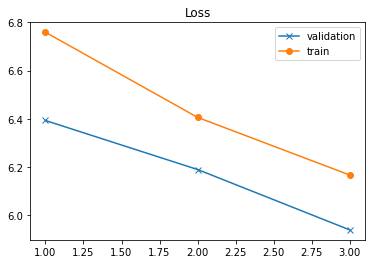

smallest val loss: (3, 5.9393387)
Current Lr:  0.00097062584

Time taken for this epoch: 400.86 secs

Epoch 4 Batch 0 Loss 6.0311


In [ ]:
ep = 1
best_val_loss = np.inf
i1,i2,i3,i4 = np.random.randint(len(short_summary_val)),np.random.randint(len(short_summary_val)),np.random.randint(len(short_summary_val)),np.random.randint(len(short_summary_val))

for epoch in range(ep,EPOCHS+1):
    ep = epoch
    start = time.time()

    train_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
        if batch % 150 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))
                  
    print()
    print(summary_generator(data_preprocessing(actual_news_val['long'][i1])))
    print(summary_generator(data_preprocessing(actual_news_val['long'][i2])))
    print()
    
    val_loss_ = validate().numpy()
    total_data['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    total_data['train'].append((epoch,train_loss.result().numpy()))
    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))  
        best_val_loss = val_loss_
    
    plotting_graph(total_data)
    print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)




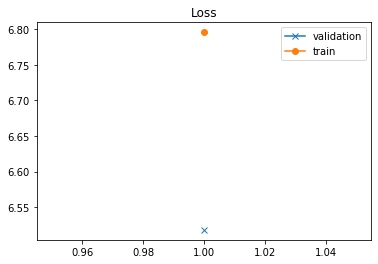

smallest val loss: (1, 6.5178356)


{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 200,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [42]:
plotting_graph(total_data)
params

In [ ]:
"""Printing the actual news and the predicted summary """
print(data_preprocessing(actual_news_val['long'][i1]))
print()
print(summary_generator(data_preprocessing(actual_news_val['long'][i1])))

In [ ]:
from rouge import rouge

In [46]:
print(rouge([data_preprocessing(actual_news_val['long'][i1])],[summary_generator(data_preprocessing(actual_news_val['long'][i1]))]))

{'rouge_1/f_score': 0.0, 'rouge_1/r_score': 0.0, 'rouge_1/p_score': 0.0, 'rouge_2/f_score': 0.0, 'rouge_2/r_score': 0.0, 'rouge_2/p_score': 0.0, 'rouge_l/f_score': 0.0, 'rouge_l/r_score': 0.0, 'rouge_l/p_score': 0.0}


In [ ]:
print(actual_news_val['long'][i1])